# Demo: Extending JAX with custom C++ and CUDA code

This demo is adapted from an example in [the exoplanet project's documentation](https://docs.exoplanet.codes/en/stable/tutorials/intro-to-pymc3/#A-more-realistic-example:-radial-velocity-exoplanets) to work with [numpyro](http://num.pyro.ai/) and the custom C++ op defined in the [Extending JAX with custom C++ and CUDA code](https://github.com/dfm/extending-jax/) tutorial. See those tutorial for all the details.

In [1]:
%matplotlib inline
!python -m pip install -q numpyro
!python -m pip install -q git+https://github.com/dfm/extending-jax.git

     |████████████████████████████████| 184kB 4.5MB/s 
     |████████████████████████████████| 481kB 7.6MB/s 
     |████████████████████████████████| 32.1MB 150kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


Download some data (see [here](https://docs.exoplanet.codes/en/stable/tutorials/intro-to-pymc3/#A-more-realistic-example:-radial-velocity-exoplanets) for more info):

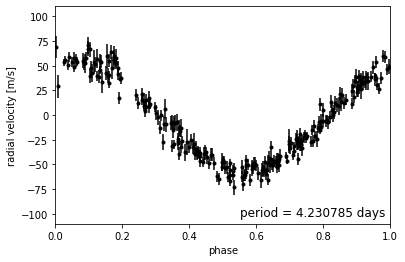

In [2]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Download the dataset from the Exoplanet Archive:
url = "https://exoplanetarchive.ipac.caltech.edu/data/ExoData/0113/0113357/data/UID_0113357_RVC_001.tbl"
r = requests.get(url)
if r.status_code != requests.codes.ok:
    r.raise_for_status()
data = np.array(
    [
        l.split()
        for l in r.text.splitlines()
        if not l.startswith("\\") and not l.startswith("|")
    ],
    dtype=float,
)
t, rv, rv_err = data.T
t -= np.mean(t)

# Plot the observations "folded" on the published period:
# Butler et al. (2006) https://arxiv.org/abs/astro-ph/0607493
lit_period = 4.230785
plt.errorbar(
    (t % lit_period) / lit_period, rv, yerr=rv_err, fmt=".k", capsize=0
)
plt.xlim(0, 1)
plt.ylim(-110, 110)
plt.annotate(
    "period = {0:.6f} days".format(lit_period),
    xy=(1, 0),
    xycoords="axes fraction",
    xytext=(-5, 5),
    textcoords="offset points",
    ha="right",
    va="bottom",
    fontsize=12,
)
plt.ylabel("radial velocity [m/s]")
_ = plt.xlabel("phase")

Fit these data using numpyro:

sample: 100%|██████████| 2000/2000 [02:16<00:00, 14.65it/s, 1023 steps of size 2.19e-03. acc. prob=0.97]


CPU times: user 2min 17s, sys: 1.31 s, total: 2min 18s
Wall time: 2min 18s


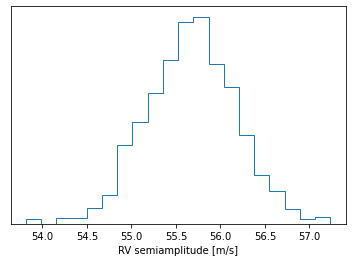

In [3]:
from jax.config import config

config.update("jax_enable_x64", True)

from jax import random
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value

from kepler_jax import kepler


def model(t, rv_err, rv=None):
    # Parameters
    K = numpyro.sample("K", dist.Uniform(10.0, 100.0))
    P = numpyro.sample("P", dist.LogNormal(np.log(4.23), 5.0))
    ecc = numpyro.sample("ecc", dist.Uniform(0.0, 1.0))

    # Handle wrapping of angles appropriately
    phi_angle = numpyro.sample("phi_angle", dist.Normal(0.0, 1.0), sample_shape=(2,))
    phi = numpyro.deterministic("phi", jnp.arctan2(phi_angle[0], phi_angle[1]))
    w_angle = numpyro.sample("w_angle", dist.Normal(0.0, 1.0), sample_shape=(2,))
    norm = jnp.sqrt(jnp.sum(w_angle ** 2))
    sinw = w_angle[0] / norm
    cosw = w_angle[1] / norm
    omega = numpyro.deterministic("omega", jnp.arctan2(sinw, cosw))

    # RV trend parameters
    rv0 = numpyro.sample("rv0", dist.Normal(0.0, 10.0))
    rv_trend = numpyro.sample("rv_trend", dist.Normal(0.0, 10.0))

    # Deterministic transformations
    bkg = numpyro.deterministic("bkg", rv0 + rv_trend * t / 365.25)
    mean_anom = 2 * np.pi * t / P - (phi + omega)

    # Solve Kepler's equation
    sinE, cosE = kepler(mean_anom, ecc)

    # MAGIC: convert to true anomaly
    tanf2 = jnp.sqrt((1 + ecc) / (1 - ecc)) * sinE / (1 + cosE)
    sinf = 2 * tanf2 / (1 + tanf2 ** 2)
    cosf = (1 - tanf2 ** 2) / (1 + tanf2 ** 2)

    # Evaluate the RV model
    rv_model = numpyro.deterministic(
        "rv_model", bkg + K * (cosw * (cosf + ecc) - sinw * sinf)
    )

    # Condition on the observations
    numpyro.sample("obs", dist.Normal(bkg + rv_model, rv_err), obs=rv)


# It's often useful to initialize well
init_values = {
    "K": 56.0,
    "P": 4.230785,
    "ecc": 0.01,
    "phi_angle": np.array([0.85, 0.5]),
    "w_angle": np.array([0.0, 1.0]),
    "rv0": -1.8,
    "rv_trend": -1.6,
}

nuts_kernel = NUTS(
    model,
    dense_mass=True,
    target_accept_prob=0.95,
    init_strategy=init_to_value(values=init_values),
)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000, num_chains=1)
rng_key = random.PRNGKey(42307)
%time mcmc.run(rng_key, t, rv_err, rv=rv)

samples = mcmc.get_samples()
plt.hist(samples["K"], 20, histtype="step")
plt.yticks([])
plt.xlabel("RV semiamplitude [m/s]");

This works, but samples a lot slower than the _exoplanet_ example so I'm not totally sure what's up with that!